In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import math
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
def missing_value_imputation(continuous_var,dataframes): #Filling the missing values
	loc_1 = [4,3,12,22]
	loc_2 = [23,20,17,16,14,11,9,5]
	loc_3 = [27,26,25,21,18,15,13,8,2,0]
	loc_4 = [10,24,6,7,19,1]
	locations = [loc_1,loc_2,loc_3,loc_4]
	for var in continuous_var:
		print var
		for dataframe_name in dataframes:
			loc_value = 1
			for loc in locations:
				only_loc = dataframe_name[dataframe_name['Location_Type']==loc_value]
				grouped = only_loc[['Date',var]].groupby(['Date']).mean()
				dic = {}
				for index,row in grouped.iterrows():
				    dic[index] = row[var]
				for park in loc:
				    c = 0
				    for index,row in dataframe_name.iterrows():
				        if(row['Park_ID']==park and math.isnan(row[var])):
				        	dataframe_name.set_value(index,var,dic[row['Date']])
				loc_value+=1
	#print "Missing Value Imputation Done."


In [33]:
def noise_removal(dataframes): #Transformation/Scaling down of noise in the data
	for dataframe_name in dataframes:
		for index,row in dataframe_name.iterrows():
			if(row['Var1']>400):
				a1 = 200.0 + (row['Var1']-400)/4.0
				dataframe_name.set_value(index,'Var1',a1)
			if(row['Max_Atmospheric_Pressure']>8600):
				a2 = row['Max_Atmospheric_Pressure']-100.0
				dataframe_name.set_value(index,'Max_Atmospheric_Pressure',a2)
			if(row['Min_Atmospheric_Pressure']<7900):
				a3 = 7900+(7900-row['Min_Atmospheric_Pressure'])/50.0
				dataframe_name.set_value(index,'Min_Atmospheric_Pressure',a3)
			if(row['Max_Ambient_Pollution']<100):
				a4 = row['Max_Ambient_Pollution']+50.0
				dataframe_name.set_value(index,'Max_Ambient_Pollution',a4)
			if(row['Average_Moisture_In_Park']<100):
				a5 = (100-row['Average_Moisture_In_Park'])+100.0
				dataframe_name.set_value(index,'Average_Moisture_In_Park',a5)
			if(row['Min_Moisture_In_Park']<50):
				a6 = (50-row['Min_Moisture_In_Park'])+50.0
				dataframe_name.set_value(index,'Min_Moisture_In_Park',a6)
			if(row['Max_Moisture_In_Park']<150):
				a7 = (150-row['Max_Moisture_In_Park'])+150.0
				dataframe_name.set_value(index,'Max_Moisture_In_Park',a7)
	
	for dataframe_name in dataframes:
		for index,row in dataframe_name.iterrows():
			if(row['Min_Atmospheric_Pressure']<7950):
				a1 = row['Min_Atmospheric_Pressure']+50.0
				dataframe_name.set_value(index,'Min_Atmospheric_Pressure',a1)

#print "Noise Removal Done."

In [34]:
def run_model(model,dtrain,predictor_var,target,scoring_method='mean_squared_error'):
#For cross-validation
    cv_method = KFold(len(dtrain),5)
    cv_scores = cross_val_score(model,dtrain[predictor_var],dtrain[target],cv=cv_method,scoring=scoring_method)
    print cv_scores, np.mean(cv_scores), np.sqrt((-1)*np.mean(cv_scores))
    
    dtrain_for_val = dtrain[dtrain['Year']<2000]
    dtest_for_val = dtrain[dtrain['Year']>1999]
    cv_method = KFold(len(dtrain_for_val),5)
    cv_scores_2 = cross_val_score(model,dtrain_for_val[predictor_var],dtrain_for_val[target],cv=cv_method,scoring=scoring_method)
    print cv_scores_2, np.mean(cv_scores_2)
    
    dtrain_for_val_ini = dtrain_for_val[predictor_var]
    dtest_for_val_ini = dtest_for_val[predictor_var]
    model.fit(dtrain_for_val_ini,dtrain_for_val[target])
    pred_for_val = model.predict(dtest_for_val_ini)
        
print math.sqrt(mean_squared_error(dtest_for_val['Footfall'],pred_for_val))

NameError: name 'dtest_for_val' is not defined

In [36]:
def generate_csv(model,dtrain,dtest,predictor_var,target,filename): #Generation of Solution file
    dtrain_ini = dtrain[predictor_var]
    model.fit(dtrain_ini,dtrain[target])
    dtest_ini = dtest[predictor_var]
    pred = model.predict(dtest_ini)
    test_for_sub = pd.read_csv('test.csv')
    test_for_sub[target] = 0
    i = 0
    for index,row in test_for_sub.iterrows():
        test_for_sub.set_value(index,target,pred[i])
        i+=1
    test_for_sub.to_csv(filename,columns=('ID',target),index=False)


In [4]:
#Reading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train.head()

,ID,Park_ID,Date,Direction_Of_Wind,Average_Breeze_Speed,Max_Breeze_Speed,Min_Breeze_Speed,Var1,Average_Atmospheric_Pressure,Max_Atmospheric_Pressure,Min_Atmospheric_Pressure,Min_Ambient_Pollution,Max_Ambient_Pollution,Average_Moisture_In_Park,Max_Moisture_In_Park,Min_Moisture_In_Park,Location_Type,Footfall
0,3311712,12,01-09-1990,194.0,37.24,60.8,15.2,92.1300,8225.0,8259.0,8211.0,92.0,304.0,255.0,288.0,222.0,3,1406
1,3311812,12,02-09-1990,285.0,32.68,60.8,7.6,14.1100,8232.0,8280.0,8205.0,172.0,332.0,252.0,297.0,204.0,3,1409
2,3311912,12,03-09-1990,319.0,43.32,60.8,15.2,35.6900,8321.0,8355.0,8283.0,236.0,292.0,219.0,279.0,165.0,3,1386
3,3312012,12,04-09-1990,297.0,25.84,38.0,7.6,0.0249,8379.0,8396.0,8358.0,272.0,324.0,225.0,261.0,192.0,3,1365
4,3312112,12,05-09-1990,207.0,28.88,45.6,7.6,0.8300,8372.0,8393.0,8335.0,236.0,332.0,234.0,273.0,183.0,3,1413


In [9]:
train.dtypes

ID                                int64
Park_ID                           int64
Date                             object
Direction_Of_Wind               float64
Average_Breeze_Speed            float64
Max_Breeze_Speed                float64
Min_Breeze_Speed                float64
Var1                            float64
Average_Atmospheric_Pressure    float64
Max_Atmospheric_Pressure        float64
Min_Atmospheric_Pressure        float64
Min_Ambient_Pollution           float64
Max_Ambient_Pollution           float64
Average_Moisture_In_Park        float64
Max_Moisture_In_Park            float64
Min_Moisture_In_Park            float64
Location_Type                     int64
Footfall                          int64
dtype: object

In [39]:

#Dividing features into Categorical and Continuous
categorical_var = ['Park_ID','Dat','Month','Year','Location_Type']
continuous_var = ['Direction_Of_Wind','Average_Breeze_Speed','Max_Breeze_Speed','Min_Breeze_Speed','Var1','Average_Atmospheric_Pressure','Max_Atmospheric_Pressure','Min_Atmospheric_Pressure','Min_Ambient_Pollution','Max_Ambient_Pollution','Average_Moisture_In_Park','Max_Moisture_In_Park','Min_Moisture_In_Park']

dataframes = [train,test]


In [40]:
train.shape


(114539, 18)

In [41]:
missing_value_imputation(continuous_var,train)

Direction_Of_Wind


TypeError: string indices must be integers, not str

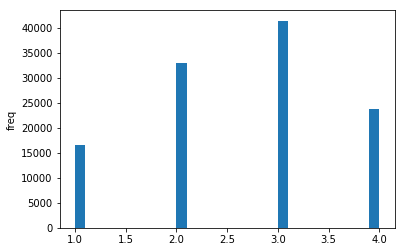

In [11]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
plt.clf()
plt.hist(train['Location_Type'],bins=30)
plt.ylabel('freq')
fig1=plt.gcf()
fig1


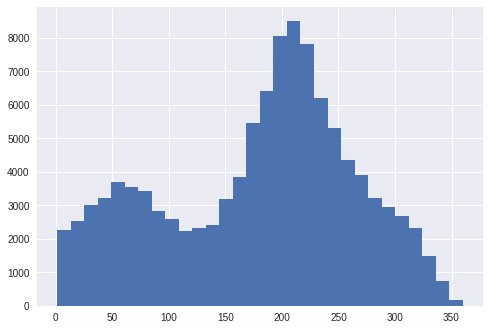

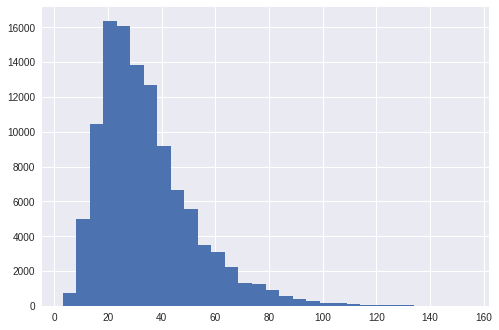

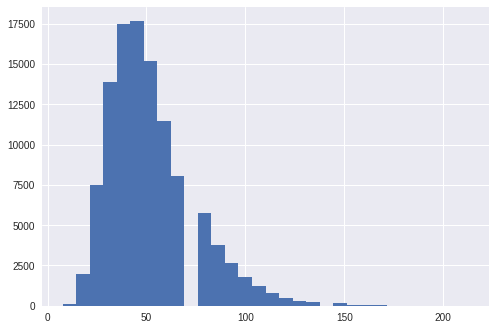

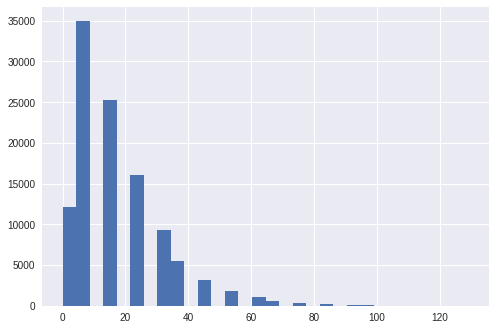

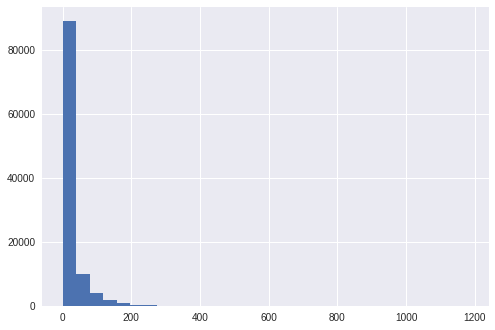

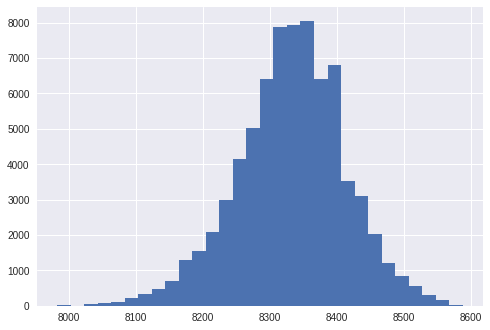

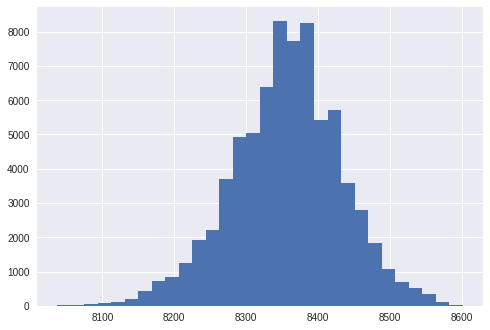

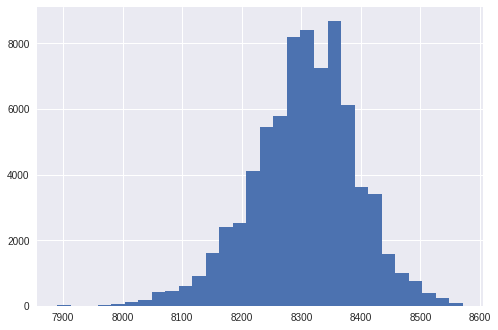

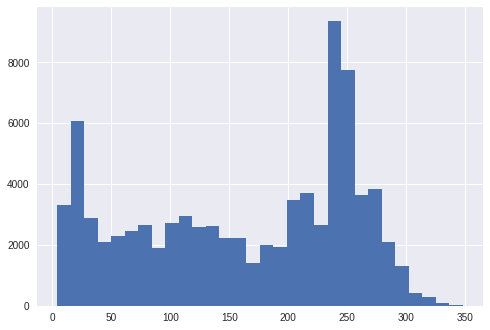

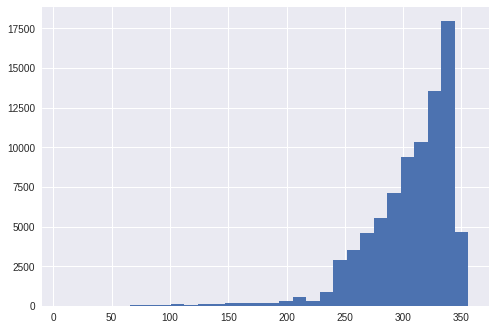

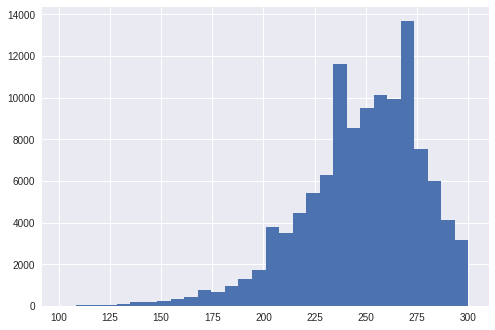

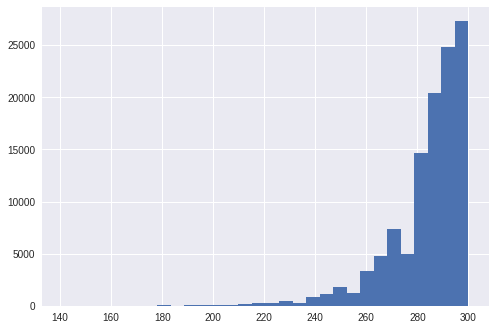

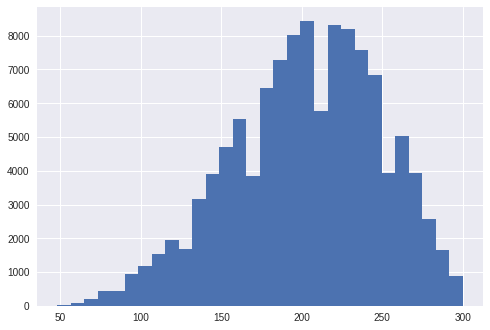

In [43]:
for name in continuous_var:
    plt.hist(train[name].dropna(),bins=30)
    plt.show()

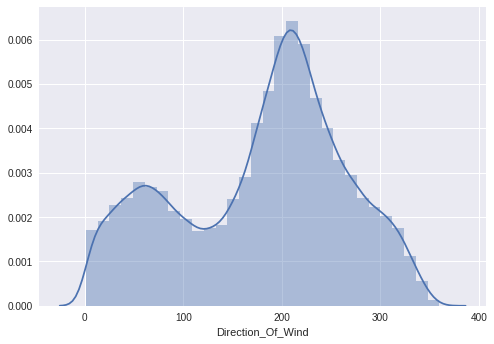

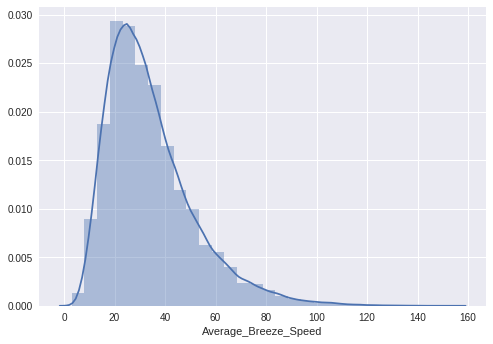

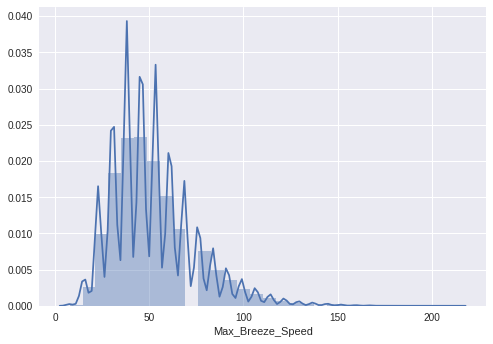

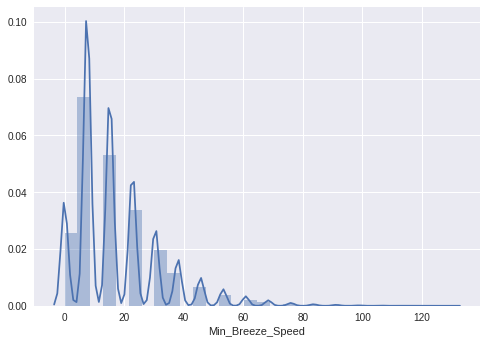

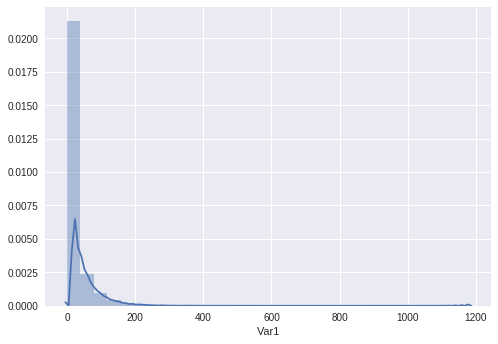

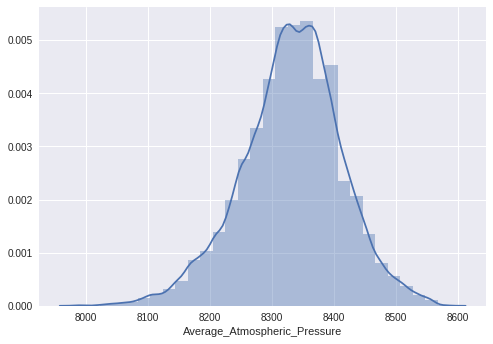

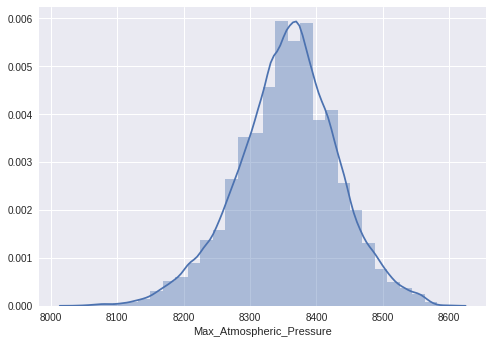

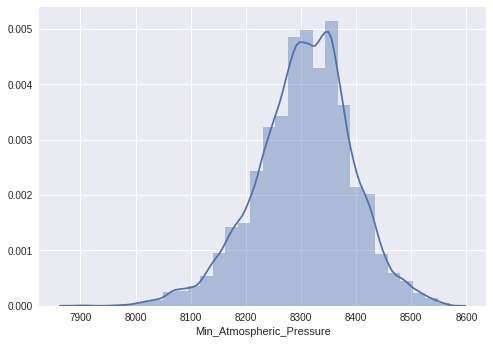

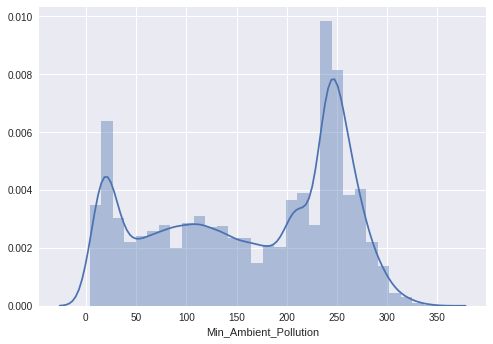

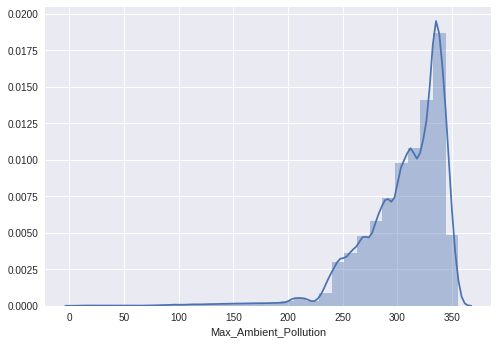

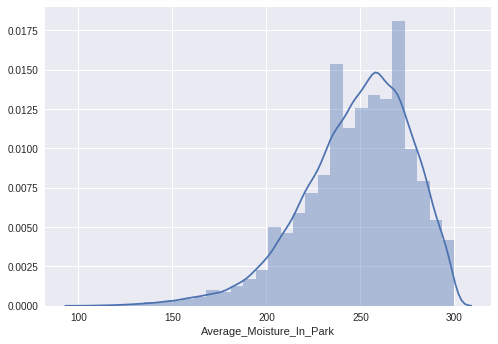

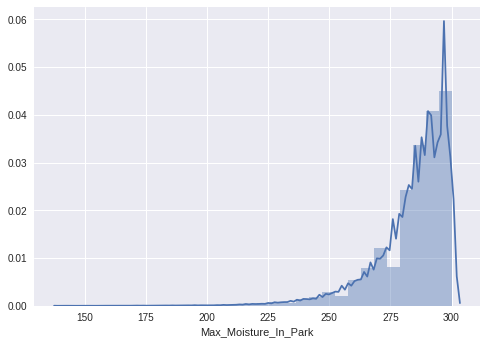

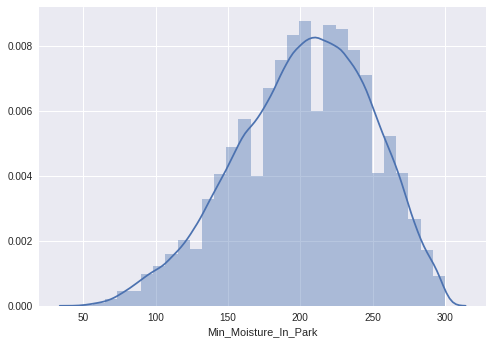

In [42]:
for name in continuous_var:
    sns.distplot(train[name].dropna(),bins=30)
    plt.show()

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

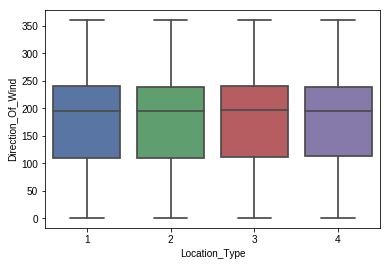

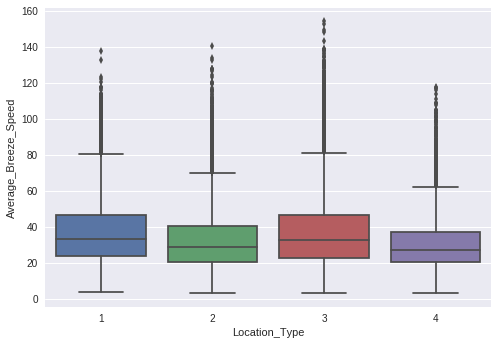

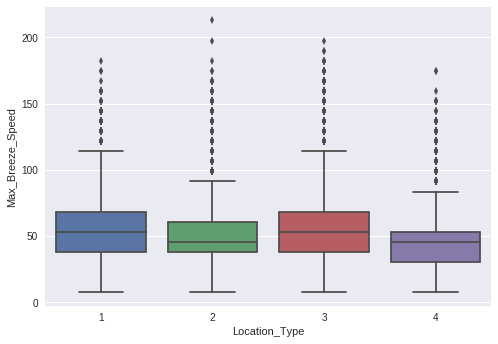

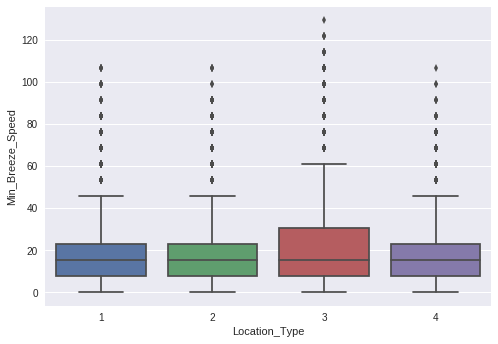

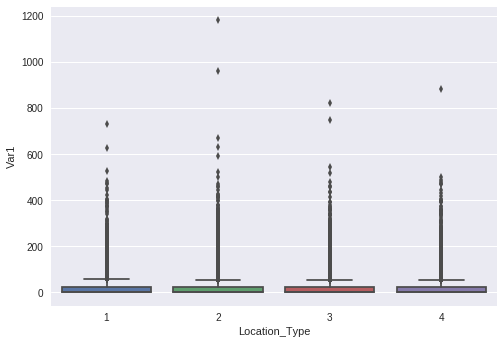

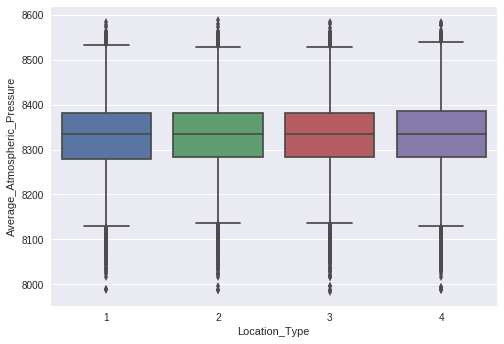

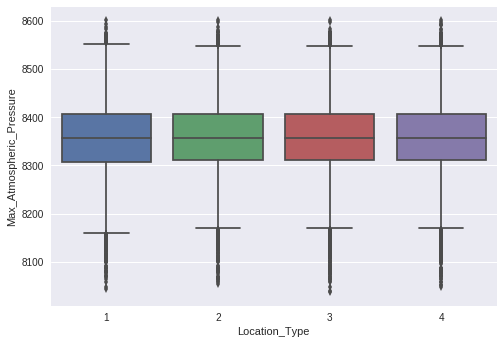

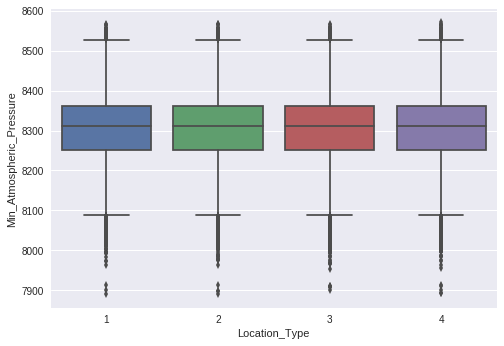

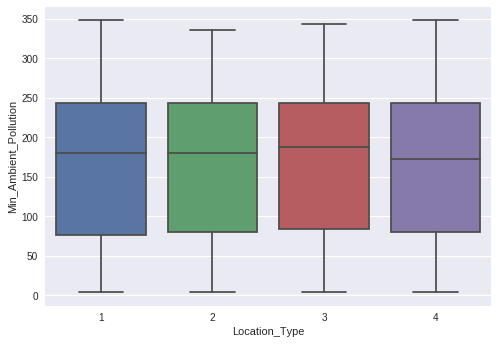

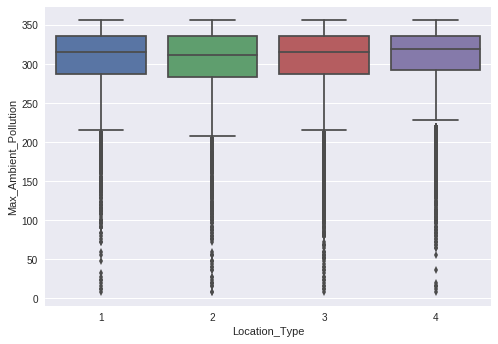

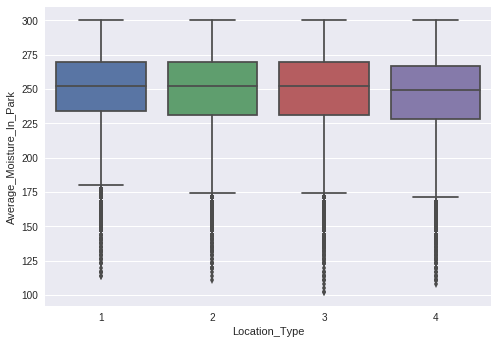

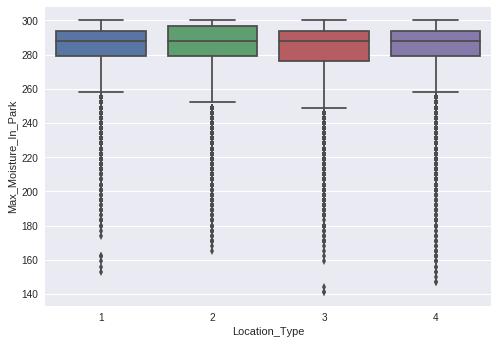

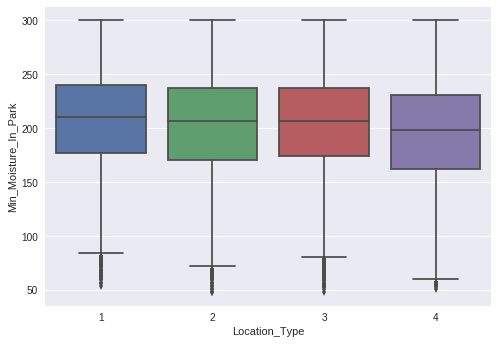

In [19]:


for name in continuous_var:
     sns.boxplot(x="Location_Type",y=name,data=train)
     plt.show()

In [23]:
train[continuous_var].corr()

,Direction_Of_Wind,Average_Breeze_Speed,Max_Breeze_Speed,Min_Breeze_Speed,Var1,Average_Atmospheric_Pressure,Max_Atmospheric_Pressure,Min_Atmospheric_Pressure,Min_Ambient_Pollution,Max_Ambient_Pollution,Average_Moisture_In_Park,Max_Moisture_In_Park,Min_Moisture_In_Park
Direction_Of_Wind,1.000000,0.130190,0.174913,0.053646,0.144963,-0.113537,-0.096337,-0.133386,0.044231,0.122890,0.131413,0.108886,0.110538
Average_Breeze_Speed,0.130190,1.000000,0.939240,0.879702,0.241275,-0.338415,-0.284753,-0.372108,0.287912,0.029159,-0.004368,-0.294786,0.171017
Max_Breeze_Speed,0.174913,0.939240,1.000000,0.739617,0.280360,-0.360265,-0.298931,-0.403972,0.261887,0.089219,-0.015761,-0.242604,0.122521
Min_Breeze_Speed,0.053646,0.879702,0.739617,1.000000,0.159921,-0.262979,-0.228288,-0.280722,0.259042,-0.053827,0.030279,-0.302916,0.207190
Var1,0.144963,0.241275,0.280360,0.159921,1.000000,-0.373926,-0.329983,-0.387436,-0.077260,-0.003581,0.231970,0.140922,0.202088
Average_Atmospheric_Pressure,-0.113537,-0.338415,-0.360265,-0.262979,-0.373926,1.000000,0.974096,0.975541,-0.038343,-0.046624,-0.153256,-0.050730,-0.172049
Max_Atmospheric_Pressure,-0.096337,-0.284753,-0.298931,-0.228288,-0.329983,0.974096,1.000000,0.913437,-0.044225,-0.054715,-0.122840,-0.038282,-0.138939
Min_Atmospheric_Pressure,-0.133386,-0.372108,-0.403972,-0.280722,-0.387436,0.975541,0.913437,1.000000,-0.041464,-0.047115,-0.168049,-0.057040,-0.189426
Min_Ambient_Pollution,0.044231,0.287912,0.261887,0.259042,-0.077260,-0.038343,-0.044225,-0.041464,1.000000,0.463705,-0.532786,-0.627203,-0.363822
Max_Ambient_Pollution,0.122890,0.029159,0.089219,-0.053827,-0.003581,-0.046624,-0.054715,-0.047115,0.463705,1.000000,-0.560253,-0.266851,-0.614487


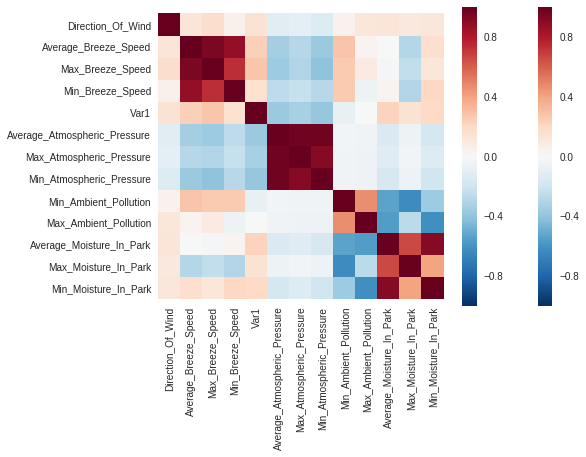

In [25]:
cor = train[continuous_var].corr()
sns.heatmap(cor,vmax=1,square=True)
plt.show()

In [44]:
#Reading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Dividing features into Categorical and Continuous
categorical_var = ['Park_ID','Dat','Month','Year','Location_Type']
continuous_var = ['Direction_Of_Wind','Average_Breeze_Speed','Max_Breeze_Speed','Min_Breeze_Speed','Var1','Average_Atmospheric_Pressure','Max_Atmospheric_Pressure','Min_Atmospheric_Pressure','Min_Ambient_Pollution','Max_Ambient_Pollution','Average_Moisture_In_Park','Max_Moisture_In_Park','Min_Moisture_In_Park']

dataframes = [train,test]

#Park_ID range: [12,39] -> [0,27], only for the sake of ease
train['Park_ID'] = train['Park_ID'] - 12
test['Park_ID'] = test['Park_ID'] - 12

In [45]:
train['Year'] = 0
for index,row in train.iterrows():
    r = row['Date']
    train.set_value(index,'Year',int(r[6])*1000+int(r[7])*100+int(r[8])*10+int(r[9]))


In [48]:
train.head()

,ID,Park_ID,Date,Direction_Of_Wind,Average_Breeze_Speed,Max_Breeze_Speed,Min_Breeze_Speed,Var1,Average_Atmospheric_Pressure,Max_Atmospheric_Pressure,...,Min_Ambient_Pollution,Max_Ambient_Pollution,Average_Moisture_In_Park,Max_Moisture_In_Park,Min_Moisture_In_Park,Location_Type,Footfall,year,month,day
0,3311712,12,1990-01-09,194.0,37.24,60.8,15.2,92.1300,8225.0,8259.0,...,92.0,304.0,255.0,288.0,222.0,3,1406,1990,1,9
1,3311812,12,1990-02-09,285.0,32.68,60.8,7.6,14.1100,8232.0,8280.0,...,172.0,332.0,252.0,297.0,204.0,3,1409,1990,2,9
2,3311912,12,1990-03-09,319.0,43.32,60.8,15.2,35.6900,8321.0,8355.0,...,236.0,292.0,219.0,279.0,165.0,3,1386,1990,3,9
3,3312012,12,1990-04-09,297.0,25.84,38.0,7.6,0.0249,8379.0,8396.0,...,272.0,324.0,225.0,261.0,192.0,3,1365,1990,4,9
4,3312112,12,1990-05-09,207.0,28.88,45.6,7.6,0.8300,8372.0,8393.0,...,236.0,332.0,234.0,273.0,183.0,3,1413,1990,5,9


In [47]:
train = pd.read_csv('train.csv', parse_dates = ['Date'])
train['year'] = train.Date.dt.year
train['month'] = train.Date.dt.month
train['day'] = train.Date.dt.day

In [ ]:
train['Dat'] = 0
for index,row in train.iterrows():
    r = row['Date']
train.set_value(index,'Dat',int(r[0])*10+int(r[1]))

In [49]:
row['Date']

'31-12-2001'

In [51]:
r[3]

'1'

In [55]:
row.shape

(19,)

In [64]:
test['Date'][2][6]

'2'